In [1]:
import random

In [2]:
from torch.version import __version__
import torch

__version__

'2.4.1'

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM


In [4]:
from torch import nn

In [5]:
# RoPE implementation borrowed from Gemma https://github.com/huggingface/transformers/blob/main/src/transformers/models/gemma/modeling_gemma.py
# Just put some comments into it to inspect it.
class GemmaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim))
        self.register_buffer("inv_freq", tensor=inv_freq, persistent=False)

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        # position_ids: [bs, seq_len]
        # x: [bs, num_attention_heads, seq_len, head_size]
        # returns cos: [bs, seq_len, head_size] where cos[b, i, j] = cos(pos_ids[b, i] * inv_freq[j])
        # returns sin: [bs, seq_len, head_size] where sin[b, i, j] = sin(pos_ids[b, i] * inv_freq[j])
        self.inv_freq.to(x.device)
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()

        print(position_ids_expanded.shape, inv_freq_expanded.shape)

        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"

        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos()
            sin = emb.sin()

        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    # if x[b, i] = ((1, 2, 3, 4, 5, 6..., a + 1, a+2, a+3..., 2a)) 
    # the rotate_half(x)[b, i] = ((-a-1, -a-2, -a-3..., -2a, 1, 2, 3, 4, 5, 6..., a))
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    # The key is that (to translate the paper notation to code notation) 
    # x_j = x[..., (j+1)//2] if j is odd
    # x_j = x[..., (head_dim + j)//2] if j is even
    # and cos[b, i, j] = cos[b, i , j + head_dim//2]

    # Such that, for j < head_dim // 2,
    # q_embed[b, i, j] = q[b, i, j] * cos[b, i, j] - q[b, i, j + head_dim // 2] * sin[b, i, j]
    # = x_j cos(theta_j) - x_{j+1} sin(theta_{j})

    # and for j >= head_dim // 2,
    # q_embed[b, i, j] = q[b, i, j] * cos[b, i, j] + q[b, i, j - head_dim // 2] * sin[b, i, j]
    # = x_j cos(theta_j) + x_{j-1} sin(theta_{j-1})

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [6]:
from transformers.models.gemma2.modeling_gemma2 import Gemma2DecoderLayer, Gemma2Config, Gemma2Attention

In [8]:
from transformers import AutoTokenizer
from torch import nn
import torch.nn.functional as F
from typing import List

from copy import deepcopy
import torch

from scipy.signal import lfilter
import numpy as np

import pandas as pd

from torch.utils.data import DataLoader

import datasets

def get_merge_dst(gate_samples: torch.Tensor) -> torch.Tensor:
    """
    Returns (merge_dst, dst_idx) the merge destination for each token in the sequence and the number of unique merge destinations.
    For now, has a janky python for-loop implementation.
    Input is a tensor of shape (batch_size, sequence_length) with 0 tokens are merged into the next 1 token.
    """
    batch_size, seq_len = gate_samples.shape
    merge_dst = torch.zeros_like(gate_samples, dtype=torch.long)
    n_dst = torch.zeros(batch_size, dtype=torch.long)

    # Process each batch separately
    for b in range(batch_size):
        dst_idx = 0
        for i in range(seq_len):
            merge_dst[b, i] = dst_idx
            if gate_samples[b, i] == 1 and i < seq_len - 1:
                # If previous position had gate=1, keep the same destination
                dst_idx += 1

        n_dst[b] = dst_idx + 1

    return merge_dst, n_dst


class GemmaMiniBitterLLM(nn.Module):
    # A mini BitterLLM with 2 down, 4 mid, and 2 up layers. As a vibe check on the idea.
    # Use Gemma2DecoderLayer as a drop in replacement for the TransformerEncoderLayer, with RoPE and sliding window pre-implemented.
    # Also uses 
    def __init__(self, vocab_size: int, embedding_dim: int, num_heads: int, dropout: float=0.01, downsample_rate: float = 0.25, sliding_window = 64):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        head_dim = embedding_dim // num_heads


        byte_layer_config = Gemma2Config(
            head_dim=head_dim,
            query_pre_attn_scalar=head_dim, 
            sliding_window=sliding_window,
            intermediate_size=embedding_dim,
            hidden_size=embedding_dim,
            num_attention_heads=num_heads,
            num_key_value_heads=num_heads,
        )

        deep_layer_config = Gemma2Config(
            head_dim=head_dim,
            query_pre_attn_scalar=head_dim, 
            sliding_window=None,
            intermediate_size=embedding_dim * 4, # dim_feedforward should scale inversely with the number of tokens in the sequence.
            hidden_size=embedding_dim,
            num_attention_heads=num_heads,
            num_key_value_heads=num_heads
        )

        
        # Layer idx=0 is necessary for the sliding window to be applied.
        self.down_layers = nn.ModuleList([
            Gemma2DecoderLayer(byte_layer_config, layer_idx=0) for _ in range(2)
        ])

        self.mid_layers = nn.ModuleList([
            Gemma2DecoderLayer(deep_layer_config, layer_idx=1) for _ in range(2) 
        ])

        self.up_layers = nn.ModuleList([
            Gemma2DecoderLayer(byte_layer_config, layer_idx=0) for _ in range(2)
        ])

        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        # Initialize a gate for each layer.
        layer_gate_init = nn.Linear(embedding_dim, 1)

        # Copy the gate for each layer. 
        # Initializing by copying inductively biases the model to tokenize in a later layer if the gate is high but the model chose not to.
        self.down_layer_gate = deepcopy(layer_gate_init)
        self.downsample_rate = downsample_rate


    def forward(self, x: torch.Tensor) -> torch.Tensor:

        batch_size, max_seq_len = x.shape


        x = self.embedding(x)

        position_ids = torch.arange(max_seq_len, dtype=x.dtype).unsqueeze(0).expand(batch_size, -1).to(x.device)

        # Apply down layers to byte tokens        
        for layer in self.down_layers:
            x = layer(x, position_ids=position_ids)[0]

        # Sample gating binary variables for each token.
        down_gate_logits = self.down_layer_gate(x)
        down_gate_probs = F.sigmoid(down_gate_logits)
        down_gate_samples = torch.bernoulli(down_gate_probs)

        # Hack: ensure for now that we always gate on the first token:
        down_gate_samples[:, 0] = 1.

        # Merge the tokens into the next token where the gate is 1.
        down_gate_samples = down_gate_samples.squeeze(-1)
        down_merge_dst, n_dst = get_merge_dst(down_gate_samples)

        # Also merge the position ids.
        position_ids_downsampled = torch.zeros(batch_size, n_dst.max(), dtype=x.dtype).to(x.device)
        position_ids_downsampled = torch.scatter_reduce(position_ids_downsampled, dim=1, index=down_merge_dst, src=position_ids, reduce="mean", include_self=False)

        # Merge the downsampled tokens.
        down_merge_dst = down_merge_dst.unsqueeze(-1).expand(-1, -1, self.embedding_dim)

        x_downsampled = torch.zeros(batch_size, n_dst.max(), self.embedding_dim, dtype=x.dtype).to(x.device)
        x_downsampled = torch.scatter_reduce(x_downsampled, dim=1, index=down_merge_dst, src=x, reduce="mean", include_self=False)

        # Apply mid layers to merged tokens and compute the deviation
        for layer in self.mid_layers:
            y_downsampled = layer(x_downsampled, position_ids=position_ids_downsampled)[0]
            deviation = y_downsampled - x_downsampled        

        # Upsample by removing the first token merge group, shifting all token groups down and adding another one token group at the end.
        up_gate_samples = down_gate_samples[:, 1:]
        up_gate_samples = torch.cat([up_gate_samples, torch.ones(batch_size, 1, dtype=up_gate_samples.dtype).to(up_gate_samples.device)], dim=1)
        up_merge_dst, _ = get_merge_dst(up_gate_samples)
        up_merge_dst = up_merge_dst.unsqueeze(-1).expand(-1, -1, self.embedding_dim)

        # Add the upsampled deviation to the input to the middle layers
        upsampled_deviation = torch.gather(deviation, dim=1, index=up_merge_dst)
        y = x + upsampled_deviation

        # Apply up layers to byte tokens
        for layer in self.up_layers:
            y = layer(y, position_ids=position_ids)[0]

        # Map residual stream to logits
        logits = self.output_layer(y)
        logits = F.log_softmax(logits, dim=-1)

        out = {
            "logits": logits,
            "down_gate_probs": down_gate_probs.squeeze(-1),
            "down_gate_logits": down_gate_logits.squeeze(-1),
            "down_gate_samples": down_gate_samples.to(dtype=torch.long),
            "down_merge_dst": down_merge_dst[:, :, 0], # This dimension is repeated.
            "up_merge_dst": up_merge_dst[:, :, 0],
            "n_dst": n_dst,
        }

        return out


In [9]:
my_model = GemmaMiniBitterLLM(vocab_size=5, embedding_dim=128, num_heads=8, dropout=0.01, downsample_rate=0.25, sliding_window=64)
my_model

GemmaMiniBitterLLM(
  (embedding): Embedding(5, 128)
  (down_layers): ModuleList(
    (0-1): 2 x Gemma2DecoderLayer(
      (self_attn): Gemma2Attention(
        (q_proj): Linear(in_features=128, out_features=128, bias=False)
        (k_proj): Linear(in_features=128, out_features=128, bias=False)
        (v_proj): Linear(in_features=128, out_features=128, bias=False)
        (o_proj): Linear(in_features=128, out_features=128, bias=False)
        (rotary_emb): Gemma2RotaryEmbedding()
      )
      (mlp): Gemma2MLP(
        (gate_proj): Linear(in_features=128, out_features=128, bias=False)
        (up_proj): Linear(in_features=128, out_features=128, bias=False)
        (down_proj): Linear(in_features=128, out_features=128, bias=False)
        (act_fn): PytorchGELUTanh()
      )
      (input_layernorm): Gemma2RMSNorm((128,), eps=1e-06)
      (pre_feedforward_layernorm): Gemma2RMSNorm((128,), eps=1e-06)
      (post_feedforward_layernorm): Gemma2RMSNorm((128,), eps=1e-06)
      (post_attenti

In [10]:
test_x = torch.randint(0, 5, (1, 10))
my_model(test_x)

{'logits': tensor([[[-3.4997, -1.6342, -0.4634, -1.9606, -5.3536],
          [-3.6049, -1.5426, -0.4805, -1.9941, -5.4257],
          [-0.8375, -0.9508, -1.9090, -3.5295, -5.7440],
          [-3.6600, -2.7093, -0.1224, -4.8673, -4.1850],
          [-1.1130, -0.6340, -1.9766, -7.1777, -6.4087],
          [-4.3619, -3.3550, -0.0650, -4.6044, -5.2462],
          [-3.5489, -1.5200, -0.5002, -1.9578, -5.3101],
          [-3.5952, -1.4244, -0.5281, -1.9854, -5.3275],
          [-3.7640, -3.1122, -0.0843, -4.8573, -5.2315],
          [-1.7456, -0.5517, -1.4443, -5.4665, -4.6755]]],
        grad_fn=<LogSoftmaxBackward0>),
 'down_gate_probs': tensor([[0.7067, 0.7083, 0.5357, 0.6453, 0.5482, 0.6511, 0.7138, 0.7026, 0.6546,
          0.4189]], grad_fn=<SqueezeBackward1>),
 'down_gate_logits': tensor([[ 0.8794,  0.8869,  0.1431,  0.5985,  0.1933,  0.6237,  0.9138,  0.8598,
           0.6395, -0.3274]], grad_fn=<SqueezeBackward1>),
 'down_gate_samples': tensor([[1, 1, 0, 1, 1, 1, 1, 1, 0, 1]]),
 'd

In [2]:
upper_patterns = ["10110", "0010"]
lower_patterns = ["ABAA", "BBAAB"]

imputed_upper_patterns = [
    p.replace("0", lower_patterns[0]).replace("1", lower_patterns[1]) for p in upper_patterns
]
imputed_upper_patterns

['BBAABABAABBAABBBAABABAA', 'ABAAABAABBAABABAA']

In [3]:
def sample(n_upper):
    choices = [random.randint(0, 1) for _ in range(n_upper)]

    x = "".join(
        imputed_upper_patterns[c] for c in choices
    )
    return x, choices


In [4]:
sample(10)

('BBAABABAABBAABBBAABABAAABAAABAABBAABABAAABAAABAABBAABABAAABAAABAABBAABABAAABAAABAABBAABABAAABAAABAABBAABABAABBAABABAABBAABBBAABABAABBAABABAABBAABBBAABABAABBAABABAABBAABBBAABABAAABAAABAABBAABABAA',
 [0, 1, 1, 1, 1, 1, 0, 0, 0, 1])

In [5]:
# Idea: force MiniBitterLM to learn these strings, with a context windom of 4 for the initial tokens.
# In theory, there should be less than 2 / (6 + 4) * (4 + 6) = 1/50 bits per character.

In [ ]:
my_dataset = [sample(10) for _ in range(1000)]

In [17]:


def compute_discounted_rewards(rewards, discount):
    """
    Assumes that rewards is a numpy array of shape (n_episodes, n_timesteps). Returns tensor of same shape.
    credit to: https://stackoverflow.com/questions/47970683/vectorize-a-numpy-discount-calculation/47971187#47971187,
    minor modifications made to vectorise computation.
    C[i] = R[i] + discount * C[i+1]
    signal.lfilter(b, a, x, axis=-1, zi=None)
    a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                          - a[1]*y[n-1] - ... - a[N]*y[n-N]
    """
    r = rewards[:, ::-1]
    a = [1, -discount]
    b = [1]
    y = lfilter(b, a, x=r)
    return y[:, ::-1]


def discounted_rewards_torch(rewards, discount):
    """torch wrapper for compute_discounted_rewards. Warning: does _not_ allow for backprop through the rewards, which is fine for policy gradients."""
    rewards_device = rewards.device
    rewards = rewards.detach().cpu().numpy()
    discounted_rewards = compute_discounted_rewards(rewards, discount)
    discounted_rewards = torch.tensor(discounted_rewards.copy(), device=rewards_device) # Copy as torch doesn't like converting negatively strided arrays
    return discounted_rewards


def bitter_tokenizer_training_step(model, batch, optimizer):
    """
    Assume that batch is torch.tensor of token ids of shape (batch, sequence_length). returns a dict of floats of the training losses for the batch.
    """
    batch_size, _ = batch.shape

    optimizer.zero_grad()

    out = model(batch)
    logits = out["logits"]
    down_gate_samples = out["down_gate_samples"]
    down_gate_probs = out["down_gate_probs"]
    down_gate_logits = out["down_gate_logits"]
    
    # Compute autoregressive loss: log probability of next token.
    next_token_ids = batch[:, 1:]
    current_token_logits = logits[:, :-1]
    next_token_logits = F.cross_entropy(current_token_logits.transpose(1, 2), next_token_ids, reduction="none") # Transpose as F.cross_entropy wants shape [batch, classes, ...]
    ar_loss = next_token_logits.mean()

    # Compute gating loss: discounted log probabilities of following token(s).
    discount_rate = 0.99
    next_token_logits_padded = torch.cat([next_token_logits, torch.zeros(batch_size, 1, device=next_token_logits.device)], dim=-1) # Pad the last reward as zero
    discounted_rewards = discounted_rewards_torch(next_token_logits_padded, discount_rate)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) # Simple estimate of the advantage
    return discounted_rewards

    # action 0 = continue, action 1 = gate
    action_log_probs = torch.stack([torch.zeros_like(down_gate_logits), down_gate_logits], dim=1) # As a sigmoid is equivalent to having one logit as 0.
    selected_action_log_probs = F.cross_entropy(action_log_probs, down_gate_samples, reduction="none")
    gating_loss = - (discounted_rewards * selected_action_log_probs).mean() # Negative as we want to maximise the reward.

    # Hacky additional consistency loss: make the downsampling rate match the training gating.
    down_gate_rate_loss =  5.*(model.downsample_rate - down_gate_probs.mean()) **2

    # Optimizer step
    total_loss = ar_loss + gating_loss + down_gate_rate_loss

    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    

    out = {
        "ar_loss": ar_loss.item(),
        "gating_loss": gating_loss.item(),
        "rate_consistency_loss": down_gate_rate_loss.item(),
        "total_loss": total_loss.item(),
        "selected_action_ce": selected_action_log_probs.mean().item()
    }

    return out


In [18]:
device = "cuda"

In [29]:
my_batch = torch.randint(0, 5, (10, 500)).to(device)
my_model = my_model.to(device)
dummy_optim = torch.optim.Adam(my_model.parameters(), lr=0.)

In [30]:
out = bitter_tokenizer_training_step(my_model, my_batch, dummy_optim)

In [31]:
import matplotlib.pyplot as plt

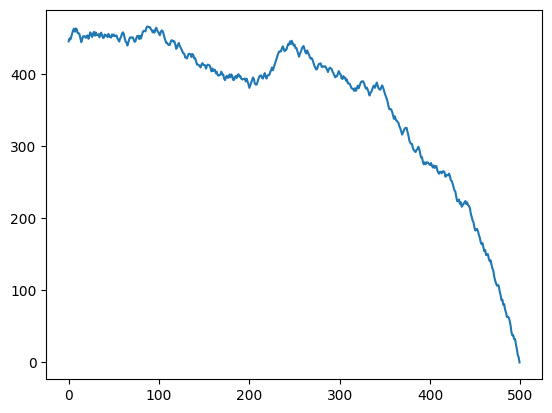

In [28]:
ce = out

plt.plot(out[:].to("cpu"))

In [ ]:

def display_gating(tokens_ids, merge_dst):
    """Display how a SmallBitterLLM merges a sequence. token_ids and merge_dst are tensors of shape (sequence_length,)."""
    previous_merge_dst = 0
    for t_id, merge_destinantion in zip(tokens_ids, merge_dst):
        merge_destinantion = merge_destinantion.item()
        
        t_txt = byte5_tokenizer.decode(t_id)
        print(f"{t_txt.replace('\n', '\\n')}", end="")

        if merge_destinantion != previous_merge_dst:
            print(f"|", end="")
            previous_merge_dst = merge_destinantion

    print()
        


def bitter_tokenizer_training_loop(model, train_dataset):
    # TODO: validation dataset
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    # See how the model merges a sequence.
    test_string = openwebtext_8k[-1]["text"][:200]
    print(f"{test_string.replace('\n', '\\n')}")
    test_batch = byte5_tokenizer.encode(test_string, return_tensors="pt", padding=True).to(device)

    # Initialize model and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    
    # Start memory tracking
    tracemalloc.start()
    
    # Training loop
    num_epochs = 2
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        model = model.to(device)
        train_losses = []

        print(f"Epoch {epoch+1}/{num_epochs}, GPU usage:")
        display_gpu_memory()
        
        # CPU memory tracking
        process = psutil.Process()
        print(f"CPU Memory before epoch: {process.memory_info().rss / (1024 * 1024):.2f} MB")

        batch_count = 0
        for batch in train_loader:

            batch = batch["text"]
            batch = byte5_tokenizer(batch, return_tensors="pt", padding=True)["input_ids"]
            batch = batch[:, :4096]  # Truncate to maximum length of 4096 to save GPU memory.
            batch = batch.to(device)

            loss_dict = bitter_tokenizer_training_step(model, batch, optimizer)
            train_losses.append(loss_dict)

            # Memory tracking for each batch
            if batch_count % 10 == 0:
                # print(f"CPU Memory at batch {batch_count}: {process.memory_info().rss / (1024 * 1024):.2f} MB")
                # current, peak = tracemalloc.get_traced_memory()
                # print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")
                
                # # Force garbage collection to see if memory is being properly released
                # gc.collect()
                # print(f"After GC: {process.memory_info().rss / (1024 * 1024):.2f} MB")
                print(f"Batch {batch_count} ar train loss: {loss_dict['ar_loss']} nats/token")
                with torch.no_grad():
                    out = model(test_batch)
                display_gating(test_batch[0], out["down_merge_dst"][0])

            batch_count += 1

        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train loss: {np.mean([l['total_loss'] for l in train_losses]):.4f}")
        
        # Memory snapshot at end of epoch
        print(f"CPU Memory after epoch: {process.memory_info().rss / (1024 * 1024):.2f} MB")
        snapshot = tracemalloc.take_snapshot()
        top_stats = snapshot.statistics('lineno')
        print("[ Top 10 memory consumers ]")
        for stat in top_stats[:10]:
            print(stat)
    
    # Stop memory tracking
    tracemalloc.stop()
    
    train_losses = pd.DataFrame(train_losses)

    return train_losses